In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from dataLoad import PulsarData
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import shap
from yellowbrick.style import set_palette

In [2]:
# For pretty plotting
plt.style.use('seaborn-paper')
plt.rcParams["font.family"] = "serif"
set_palette('flatui')

Load in the data:

In [3]:
raw_features = PulsarData('HTRU_2').features
raw_targets = PulsarData('HTRU_2').targets

Calculate the percentage of each class:

In [4]:
print(f'The data set contains {PulsarData("HTRU_2").baseline*100:.1f} % pulsars of class 0 and {(1-PulsarData("HTRU_2").baseline)*100:.1f} % pulsars of class 1')

The data set contains 90.8 % pulsars of class 0 and 9.2 % pulsars of class 1


Correlations:

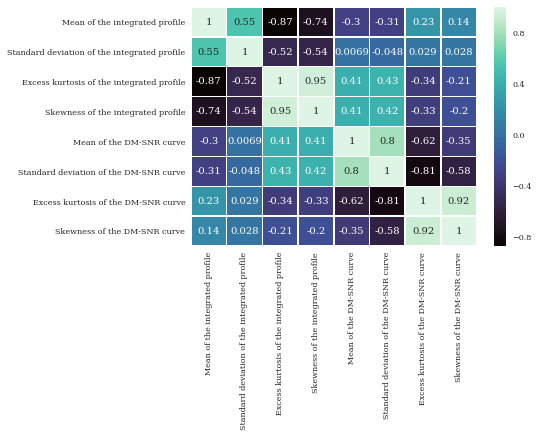

In [5]:
plt.figure(1)
_ = sns.heatmap(raw_features.corr(), annot=True, linewidth=0.5, cmap='mako')
plt.savefig('plots/Correlations.pdf')

In [6]:
#plt.figure(2)
#_ = sns.pairplot(PulsarData('HTRU_2').data, kind='scatter', hue='Class', plot_kws = dict(ec='w'))
#plt.savefig('plots/Pairplot.pdf')

Monte Carlo simmulation of each class (pulsars and noise):

In [23]:
MC_size = 5000

In [24]:
MC_list = list()
for i in range(2):
    features = raw_features[raw_targets == i]
    features = features.reset_index(drop=True)
    means = np.mean(features, axis=0)
    cov_matrix = features.corr()
    mc_features = stats.multivariate_normal(mean=means, cov=cov_matrix).rvs(MC_size, random_state=27)
    mc_features = pd.DataFrame(data=mc_features, columns = features.columns)
    mc_features['Class'] = np.ones(MC_size, dtype=int) * int(i)
    MC_list.append(mc_features)

Collecting all data in 1 dataframe and shuffling indexes:

In [27]:
MC_data = pd.concat(MC_list).sample(frac=1).reset_index(drop=True)